## Setup

In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

Error importing in API mode: ImportError("dlopen(/Users/luizaswierzawska1/.pyenv/versions/3.13.9/lib/python3.13/site-packages/_rinterface_cffi_api.abi3.so, 0x0002): Library not loaded: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib\n  Referenced from: <B96A8100-FA7A-3EFC-8726-931D26646DE6> /Users/luizaswierzawska1/.pyenv/versions/3.13.9/lib/python3.13/site-packages/_rinterface_cffi_api.abi3.so\n  Reason: tried: '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file)")
Trying to import in ABI mode.


In [2]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## TidyCensus Example

This notebook grabs data from the US Census using the [tidycensus package in R](https://walker-data.com/tidycensus/index.html). Make sure you have installed the `tidyverse` and `tidycensus` packages.

In [3]:
%%R 

library(tidycensus)
library(tidyverse)

# store any shapefiles we grab from the census in ~/Library/Caches/tigris
# in case the government removes the shapefiles FTP server again 😭
options(tigris_use_cache = TRUE)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.2.0     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.2     ✔ tibble    3.3.1
✔ lubridate 1.9.5     ✔ tidyr     1.3.2
✔ purrr     1.2.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


### Step 1 \| Load Census API key from `.env` file

The `.env` file should look like this:

```bash
CENSUS_API_KEY="your-api-key-here"
```

This is what is known as an environment variable. 

We load it below in Python

In [4]:
from dotenv import load_dotenv
load_dotenv() # <- searches for a file named .env and loads the environment variables in it

True

And in this cell we pass the environment variable to tidycensus in R

In [5]:
%%R 

census_api_key(Sys.getenv("CENSUS_API_KEY")) # <- Loads CENSUS_API_KEY from environment variable and sets it in R

To install your API key for use in future sessions, run this function with `install = TRUE`.


### Step 2 \| Figure out what tables you want data from and at what geographic granularity

Use <https://censusreporter.org/> to figure out which tables you want.

-   Scroll to the bottom of the page to see the tables.
-   If you already know the table ID, stick that in the "Explore" section to learn more about that table.

Note, you probably always want population variable (B01003_001) which we found in censusreporter here: https://censusreporter.org/tables/B01003/

- find some other variables that you're also interested in
- don't forget to pick a geography like "tract", "county" or "block group". here is the list of [all geographies](https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus
).

👉 use the code from the example notebooks to get the variables you're interested in. feel free to use ChatGPT for help

In [14]:
%%R 

nyc_census_data <- get_acs(geography = "tract", 
                      state = 'NY',
                      county = c("New York", "Kings", "Queens", "Bronx", "Richmond"),
                      variables = c(
                        inc_with_children = "B19125_002",
                        inc_no_children   = "B19125_003"
                      ), 
                      year = 2021,
                      survey = "acs5",
                      geometry = T,
                      output = "wide")

nyc_census_data


Simple feature collection with 2327 features and 6 fields (with 1 geometry empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
First 10 features:
         GEOID                                        NAME inc_with_childrenE
1  36081014700   Census Tract 147, Queens County, New York             108784
2  36047058400    Census Tract 584, Kings County, New York              80473
3  36061006900  Census Tract 69, New York County, New York             250001
4  36047073000    Census Tract 730, Kings County, New York             121000
5  36047100400   Census Tract 1004, Kings County, New York              90250
6  36047055700    Census Tract 557, Kings County, New York                 NA
7  36005022101 Census Tract 221.01, Bronx County, New York              52672
8  36081047000   Census Tract 470, Queens County, New York              74861
9  36047050402 Census Tract 504.02, Kings County, New 

Getting data from the 2017-2021 5-year ACS
Using FIPS code '36' for state 'NY'
Using FIPS code '061' for 'New York County'
Using FIPS code '047' for 'Kings County'
Using FIPS code '081' for 'Queens County'
Using FIPS code '005' for 'Bronx County'
Using FIPS code '085' for 'Richmond County'


### Step 3 | Pivot to Wide Format

Pivot from long to wide using `pivot_wider`.

Depending on what you're trying to do, you may want the data in long or wide format. This example pivots the data to wide format, which will help us with mapping later on in the notebook.

In [13]:
## I skipped this part because I already used output = "wide" while loading in the data. 

### Step 4 | Do calculations with `mutate`

In R, you can use `mutate` to create new columns or modify existing ones.

👉 In this step, do any calculations you need (for example if you have the total black population, but you want it as a percent of total population in a census tract, you may have to do some division)

In [17]:
%%R 

nyc_census_data <- nyc_census_data %>%
  mutate(income_ratio = inc_with_childrenE / inc_no_childrenE)

nyc_census_data


Simple feature collection with 2327 features and 7 fields (with 1 geometry empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
First 10 features:
         GEOID                                        NAME inc_with_childrenE
1  36081014700   Census Tract 147, Queens County, New York             108784
2  36047058400    Census Tract 584, Kings County, New York              80473
3  36061006900  Census Tract 69, New York County, New York             250001
4  36047073000    Census Tract 730, Kings County, New York             121000
5  36047100400   Census Tract 1004, Kings County, New York              90250
6  36047055700    Census Tract 557, Kings County, New York                 NA
7  36005022101 Census Tract 221.01, Bronx County, New York              52672
8  36081047000   Census Tract 470, Queens County, New York              74861
9  36047050402 Census Tract 504.02, Kings County, New 

In [19]:
%%R
# checking if the new column was added correctly
names(nyc_census_data)
head(nyc_census_data)

Simple feature collection with 6 features and 7 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.02097 ymin: 40.5916 xmax: -73.90051 ymax: 40.76548
Geodetic CRS:  NAD83
        GEOID                                       NAME inc_with_childrenE
1 36081014700  Census Tract 147, Queens County, New York             108784
2 36047058400   Census Tract 584, Kings County, New York              80473
3 36061006900 Census Tract 69, New York County, New York             250001
4 36047073000   Census Tract 730, Kings County, New York             121000
5 36047100400  Census Tract 1004, Kings County, New York              90250
6 36047055700   Census Tract 557, Kings County, New York                 NA
  inc_with_childrenM inc_no_childrenE inc_no_childrenM
1              29835            97537            48077
2              29879            93542            23137
3                 NA           224821           111855
4              60227           118929            2

In [23]:
%%R

# Adding boroughs for visualizations below

nyc_census_data <- nyc_census_data %>%
  mutate(borough = case_when(
    grepl("New York County", NAME)  ~ "Manhattan",
    grepl("Kings County", NAME)     ~ "Brooklyn",
    grepl("Queens County", NAME)    ~ "Queens",
    grepl("Bronx County", NAME)     ~ "Bronx",
    grepl("Richmond County", NAME)  ~ "Staten Island"
  ))

### Step 5 | Example Plots

Use histograms or dotplots to view the distributions

R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: Removed 546 rows containing non-finite outside the scale range (`stat_bin()`). 
  


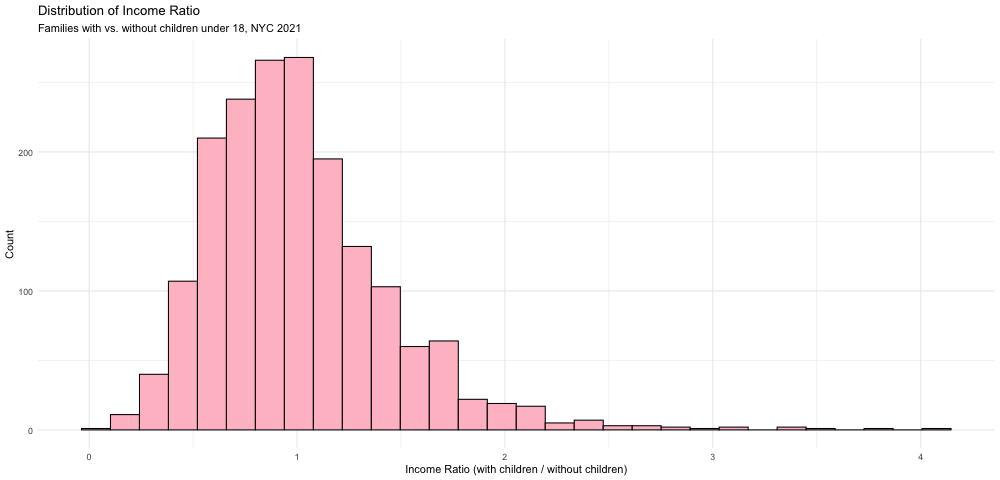

In [27]:
%%R -w 1000

ggplot(nyc_census_data) +
  geom_histogram(aes(x = income_ratio), bins = 30, fill = "pink", color = "black") +
  labs(
    title = "Distribution of Income Ratio",
    subtitle = "Families with vs. without children under 18, NYC 2021",
    x = "Income Ratio (with children / without children)",
    y = "Count"
  ) +
  theme_minimal()

I used Claude to help me lay down the explanation of what this means, so I could wrap my head around this. Ratio equal to 1 means families with and without children earn the same median income in a given tract. Ratio below 1 means that families without children earn more and ratio above 1 means families with children earn more. Looking at your histogram, since the peak is just below 1, the most common situation across NYC tracts is that families without children earn slightly more than families with children. This is plausible due to number of reasons: financial burden of childcare, parents on a work leave or reducing their work hours, and younger families with younger children still early in their careers and earning less. 

### Step 6 \| Example Map

See more details about making maps here:

https://walker-data.com/tidycensus/articles/spatial-data.html

In addition: Warning message:
Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
This warning is displayed once per session.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


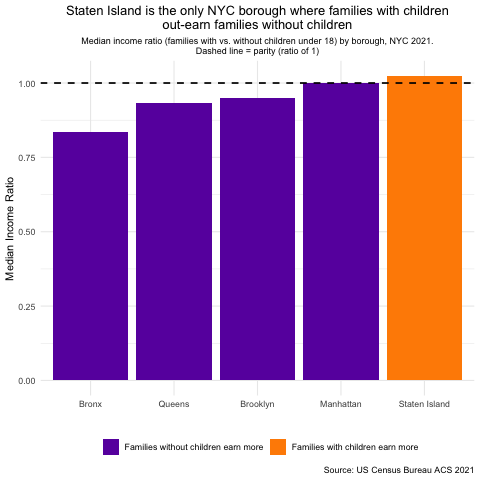

In [43]:
%%R

nyc_census_data %>%
  st_drop_geometry() %>%
  filter(!is.na(income_ratio) & !is.infinite(income_ratio)) %>%
  group_by(borough) %>%
  summarise(median_ratio = median(income_ratio)) %>%
  arrange(median_ratio) %>%
  mutate(borough = factor(borough, levels = borough)) %>%  # keep sorted order
  ggplot(aes(x = borough, y = median_ratio, fill = median_ratio > 1)) +
  geom_col() +
  geom_hline(yintercept = 1, linetype = "dashed", color = "black", size = 0.8) +
  scale_fill_manual(
    values = c("TRUE" = "#ff8c00", "FALSE" = "#6a0dad"),
    labels = c("TRUE" = "Families with children earn more", 
               "FALSE" = "Families without children earn more"),
    name = ""
  ) +
  labs(
    title = "Staten Island is the only NYC borough where families with children\nout-earn families without children",
    subtitle = "Median income ratio (families with vs. without children under 18) by borough, NYC 2021.\nDashed line = parity (ratio of 1)",
    x = "",
    y = "Median Income Ratio",
    caption = "Source: US Census Bureau ACS 2021"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 13, hjust = 0.5),
    plot.subtitle = element_text(size = 9, hjust = 0.5),
    legend.position = "bottom"
  )